In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
#from sklearn.model_selection import train_test_split
#from sklearn.linear_model import LinearRegression
#from sklearn.model_selection import KFold
#from sklearn.metrics import log_loss,mean_squared_error
import keras
from keras.models import Sequential
from keras.layers import Dense,Dropout,BatchNormalization
from keras.callbacks import ModelCheckpoint
from tqdm import tqdm

/opt/conda/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#Import the train dataset
train_id = pd.read_csv('train.csv')
train.head()

#Drop two column
train = train.drop(['id'], axis = 1)
print('Number of rows and columns in all data set:',train.shape)

train_labels = train[['formation_energy_ev_natom', 'bandgap_energy_ev']]
train_data = train.drop(['formation_energy_ev_natom', 'bandgap_energy_ev'], axis = 1)
print('Number of rows and columns in train_data data set:',train_data.shape)
print('Number of rows and columns in train_labels data set:',train_labels.shape)

('Number of rows and columns in all data set:', (2400, 13))
('Number of rows and columns in train_data data set:', (2400, 11))
('Number of rows and columns in train_labels data set:', (2400, 2))


In [3]:
#Import the test dataset
test = pd.read_csv('test.csv')
test.head()

#Drop two column
test = test.drop(['id'], axis = 1)
print('Number of rows and columns in all data set:',test.shape)

print('Number of rows and columns in test data set:',test.shape)

('Number of rows and columns in all data set:', (600, 11))
('Number of rows and columns in test data set:', (600, 11))


In [4]:
# Degree to radian
train_data['alpha_rad'] = np.radians(train_data['lattice_angle_alpha_degree'])
train_data['beta_rad'] = np.radians(train_data['lattice_angle_beta_degree'])
train_data['gamma_rad'] = np.radians(train_data['lattice_angle_gamma_degree'])

test['alpha_rad'] = np.radians(test['lattice_angle_alpha_degree'])
test['beta_rad'] = np.radians(test['lattice_angle_beta_degree'])
test['gamma_rad'] = np.radians(test['lattice_angle_gamma_degree'])

In [5]:
def vol(df):
    """
    Args:
        a (float) - lattice vector 1
        b (float) - lattice vector 2
        c (float) - lattice vector 3
        alpha (float) - lattice angle 1 [radians]
        beta (float) - lattice angle 2 [radians]
        gamma (float) - lattice angle 3 [radians]
    Returns:
        volume (float) of the parallelepiped unit cell
    """
    volumn = df['lattice_vector_1_ang']*df['lattice_vector_2_ang']*df['lattice_vector_3_ang']*np.sqrt(
    1 + 2*np.cos(df['alpha_rad'])*np.cos(df['beta_rad'])*np.cos(df['gamma_rad'])
    -np.cos(df['alpha_rad'])**2
    -np.cos(df['beta_rad'])**2
    -np.cos(df['gamma_rad'])**2)
    df['volumn'] = volumn

In [6]:
'''
def mean_median_feature(df):
        print('# Mean & Median range')
        dmean = df.mean()
        dmedian = df.median()
        #q0_1 = df.quantile(0.1)
        #q0_99 = df.quantile(0.99)
        q1 = df.quantile(0.25)
        q3 = df.quantile(0.75)
        col = df.columns
        del_col = ['id','formation_energy_ev_natom','bandgap_energy_ev']
        col = [w for w in col if w not in del_col]
        
        for c in col:
            df['mean_'+c] = (df[c] > dmean[c]).astype(np.uint8)
            df['median_'+c] = (df[c] > dmedian[c]).astype(np.uint8)
            #df['q0_1_'+c] = (df[c] < q0_1[c]).astype(np.uint8)
            #df['q0_99_'+c] = (df[c] > q0_99[c]).astype(np.uint8)
            df['q1_'+c] = (df[c] < q1[c]).astype(np.uint8)
            df['q3_'+c] = (df[c] > q3[c]).astype(np.uint8)
            
        print('Shape',df.shape)
'''

"\ndef mean_median_feature(df):\n        print('# Mean & Median range')\n        dmean = df.mean()\n        dmedian = df.median()\n        #q0_1 = df.quantile(0.1)\n        #q0_99 = df.quantile(0.99)\n        q1 = df.quantile(0.25)\n        q3 = df.quantile(0.75)\n        col = df.columns\n        del_col = ['id','formation_energy_ev_natom','bandgap_energy_ev']\n        col = [w for w in col if w not in del_col]\n        \n        for c in col:\n            df['mean_'+c] = (df[c] > dmean[c]).astype(np.uint8)\n            df['median_'+c] = (df[c] > dmedian[c]).astype(np.uint8)\n            #df['q0_1_'+c] = (df[c] < q0_1[c]).astype(np.uint8)\n            #df['q0_99_'+c] = (df[c] > q0_99[c]).astype(np.uint8)\n            df['q1_'+c] = (df[c] < q1[c]).astype(np.uint8)\n            df['q3_'+c] = (df[c] > q3[c]).astype(np.uint8)\n            \n        print('Shape',df.shape)\n"

In [7]:
vol(train_data)
vol(test)

In [8]:
#mean_median_feature(train_data)
#mean_median_feature(test) 

In [9]:
# Atomic density
train_data['density'] = train_data['number_of_total_atoms'] / train_data['volumn']
test['density'] = test['number_of_total_atoms'] / test['volumn']

In [10]:
train_data = train_data.drop(['lattice_angle_alpha_degree', 'lattice_angle_beta_degree', 'lattice_angle_gamma_degree'], axis = 1)
test = test.drop(['lattice_angle_alpha_degree', 'lattice_angle_beta_degree', 'lattice_angle_gamma_degree'], axis = 1)

In [16]:
model = Sequential()
#1 and hidden layer
model.add(Dense(units = 1024, activation = 'relu', kernel_initializer = 'glorot_uniform',input_dim = train_data.shape[1]))
model.add(Dropout(0.1))
model.add(Dense(units = 512, activation = 'relu', kernel_initializer = 'uniform'))
model.add(Dropout(0.1))
model.add(Dense(units = 256, activation = 'relu', kernel_initializer = 'uniform'))
model.add(Dropout(0.1))
model.add(Dense(units = 128, activation = 'relu', kernel_initializer = 'uniform'))
model.add(Dropout(0.1))
model.add(Dense(units = 64, activation = 'relu', kernel_initializer = 'uniform'))
model.add(Dropout(0.1))
model.add(Dense(units = 2, activation = 'relu', kernel_initializer = 'uniform'))

#compile ANN
model.compile(optimizer = 'adam', loss = 'msle', metrics =['accuracy'])
#fit
history = model.fit(train_data, train_labels, batch_size = 100, epochs = 100, validation_split=0.1)

Train on 2160 samples, validate on 240 samples
Epoch 1/100
2160/2160 [==============================] - 0s 207us/step - loss: 0.1831 - acc: 0.8944 - val_loss: 0.1202 - val_acc: 0.9958
Epoch 2/100
2160/2160 [==============================] - 0s 74us/step - loss: 0.1114 - acc: 0.9870 - val_loss: 0.1112 - val_acc: 0.9958
Epoch 3/100
2160/2160 [==============================] - 0s 68us/step - loss: 0.1036 - acc: 0.9870 - val_loss: 0.0909 - val_acc: 0.9958
Epoch 4/100
2160/2160 [==============================] - 0s 69us/step - loss: 0.0931 - acc: 0.9870 - val_loss: 0.0933 - val_acc: 0.9958
Epoch 5/100
2160/2160 [==============================] - 0s 71us/step - loss: 0.0883 - acc: 0.9870 - val_loss: 0.0786 - val_acc: 0.9958
Epoch 6/100
2160/2160 [==============================] - 0s 68us/step - loss: 0.0791 - acc: 0.9870 - val_loss: 0.0719 - val_acc: 0.9958
Epoch 7/100
2160/2160 [==============================] - 0s 79us/step - loss: 0.0614 - acc: 0.9870 - val_loss: 0.0393 - val_acc: 0.9958


2160/2160 [==============================] - 0s 78us/step - loss: 0.0111 - acc: 0.9870 - val_loss: 0.0068 - val_acc: 0.9958
Epoch 61/100
2160/2160 [==============================] - 0s 69us/step - loss: 0.0100 - acc: 0.9866 - val_loss: 0.0070 - val_acc: 0.9958
Epoch 62/100
2160/2160 [==============================] - 0s 72us/step - loss: 0.0100 - acc: 0.9856 - val_loss: 0.0073 - val_acc: 0.9958
Epoch 63/100
2160/2160 [==============================] - 0s 72us/step - loss: 0.0091 - acc: 0.9861 - val_loss: 0.0077 - val_acc: 0.9958
Epoch 64/100
2160/2160 [==============================] - 0s 79us/step - loss: 0.0092 - acc: 0.9875 - val_loss: 0.0064 - val_acc: 0.9958
Epoch 65/100
2160/2160 [==============================] - 0s 75us/step - loss: 0.0092 - acc: 0.9875 - val_loss: 0.0065 - val_acc: 0.9958
Epoch 66/100
2160/2160 [==============================] - 0s 72us/step - loss: 0.0089 - acc: 0.9856 - val_loss: 0.0071 - val_acc: 0.9958
Epoch 67/100
2160/2160 [==============================

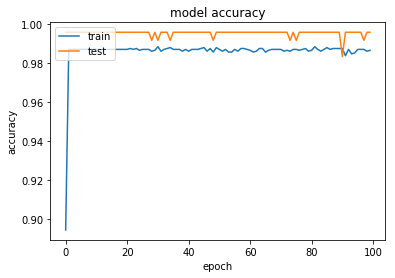

In [17]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

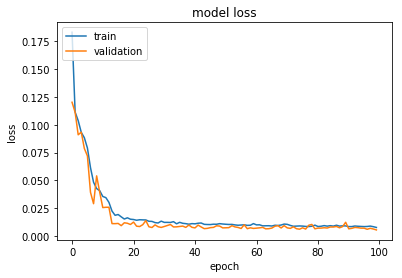

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [19]:
def rmsle(y_true,y_pred):
    return np.sqrt(np.square(np.log(y_pred + 1) - np.log(y_true + 1)).mean())

In [20]:
rmsle(train_labels, model.predict(train_data))

formation_energy_ev_natom    0.054654
bandgap_energy_ev            0.094746
dtype: float64

In [27]:
test_pred = model.predict(test)
test_pred

array([[0.21388283, 1.7098289 ],
       [0.11034668, 3.7322288 ],
       [0.11845667, 3.5372052 ],
       ...,
       [0.17630878, 0.7856753 ],
       [0.1999258 , 2.2318292 ],
       [0.21805872, 2.152522  ]], dtype=float32)

In [28]:
test_id = pd.read_csv('test.csv')

submit = pd.DataFrame({'id':test_id['id'],'formation_energy_ev_natom':test_pred[:,0],'bandgap_energy_ev':test_pred[:,1]})
submit.to_csv('submission.csv',index=False)

In [29]:
submit.head()

,bandgap_energy_ev,formation_energy_ev_natom,id
0,1.709829,0.213883,1
1,3.732229,0.110347,2
2,3.537205,0.118457,3
3,3.188421,0.101721,4
4,1.735381,0.165086,5


In [24]:
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)

In [25]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 1024)              14336     
_________________________________________________________________
dropout_7 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_8 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_9 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 128)               32896     
__________

In [26]:
model.get_config()

[{'class_name': 'Dense',
  'config': {'activation': 'relu',
   'activity_regularizer': None,
   'batch_input_shape': (None, 13),
   'bias_constraint': None,
   'bias_initializer': {'class_name': 'Zeros', 'config': {}},
   'bias_regularizer': None,
   'dtype': 'float32',
   'kernel_constraint': None,
   'kernel_initializer': {'class_name': 'VarianceScaling',
    'config': {'distribution': 'uniform',
     'mode': 'fan_avg',
     'scale': 1.0,
     'seed': None}},
   'kernel_regularizer': None,
   'name': 'dense_8',
   'trainable': True,
   'units': 1024,
   'use_bias': True}},
 {'class_name': 'Dropout',
  'config': {'name': 'dropout_7',
   'noise_shape': None,
   'rate': 0.1,
   'seed': None,
   'trainable': True}},
 {'class_name': 'Dense',
  'config': {'activation': 'relu',
   'activity_regularizer': None,
   'bias_constraint': None,
   'bias_initializer': {'class_name': 'Zeros', 'config': {}},
   'bias_regularizer': None,
   'kernel_constraint': None,
   'kernel_initializer': {'class_n